# Noise Qualification Workflow

This notebook evaluates a backend adapter with Qonscious by computing a noise figure of merit and deciding whether the backend is suitable for follow-on experiments. It also visualizes key fidelity metrics to support the decision.

**Objective:** Proceed with resource-intensive experiments only when the backend satisfies the configured noise-quality thresholds; otherwise, pause and revisit the setup.

### Workflow Summary
1. Prepare a Bell-state reference circuit that exercises the target backend.
2. Define pass/fail callbacks that report figure-of-merit metrics and conditionally run an experiment.
3. Instantiate the noise-aware backend adapter and review its configuration.
4. Configure the compliance thresholds for the figure of merit.
5. Execute the Qonscious conditional workflow with the adapter, checks, and callbacks.
6. Visualize the measurement distribution when the validation experiment runs.


## Step 1 – Prepare the reference circuit

Construct the `phi+` Bell-state circuit that acts as a lightweight validation workload when the backend meets the noise criteria.


In [1]:
from qiskit import QuantumCircuit


def build_phi_plus_circuit():
    """Create a Bell-state circuit used as a lightweight validation workload."""
    phi_plus = QuantumCircuit(2)
    phi_plus.h(0)
    phi_plus.cx(0, 1)
    phi_plus.measure_all()
    return phi_plus


## Step 2 – Define pass/fail callbacks

Implement callbacks that log the computed figure-of-merit metrics, execute the reference circuit on success, and skip execution when the backend falls short.


In [2]:
METRIC_ORDER = [
    ("overall_noise_score", "Overall noise score", 3),
    ("single_qubit_gate_fidelity", "Single-qubit gate fidelity", 3),
    ("two_qubit_gate_fidelity", "Two-qubit gate fidelity", 3),
    ("readout_fidelity", "Readout fidelity", 3),
    ("coherence_factor", "Coherence factor", 3),
    ("relaxation_time_t1_seconds", "T1 relaxation time (s)", 6),
    ("relaxation_time_t2_seconds", "T2 dephasing time (s)", 6),
    ("single_qubit_gate_duration_seconds", "Single-qubit gate duration (s)", 9),
    ("two_qubit_gate_duration_seconds", "Two-qubit gate duration (s)", 9),
    ("thermal_population_fraction", "Thermal population fraction", 4),
    ("backend_qubits", "Backend qubits", None),
    ("backend_name", "Backend name", None),
]


def _metric_summary(properties):
    summary: list[str] = []
    for key, label, decimals in METRIC_ORDER:
        if key not in properties:
            continue
        value = properties[key]
        if isinstance(value, (int, float)) and decimals is not None:
            formatted = format(value, f".{decimals}f")
        else:
            formatted = str(value)
        summary.append(f"  - {label}: {formatted}")
    return summary


def on_pass(backend_adapter, figure_of_merit_results):
    properties = {}
    if figure_of_merit_results:
        primary = figure_of_merit_results[0] or {}
        properties = primary.get("properties", {}) or {}

    print("Noise compliance check passed.")

    metrics = _metric_summary(properties)
    if metrics:
        print("Noise metrics:")
        for line in metrics:
            print(line)
    else:
        print("Noise metrics: not reported by the figure of merit.")

    print("Running the Bell-state reference circuit for verification.")
    return backend_adapter.run(build_phi_plus_circuit(), shots=2048)


def on_fail(backend_adapter, figure_of_merit_results):
    properties = {}
    if figure_of_merit_results:
        primary = figure_of_merit_results[0] or {}
        properties = primary.get("properties", {}) or {}

    print("Noise compliance check failed.")

    metrics = _metric_summary(properties)
    if metrics:
        print("Noise metrics:")
        for line in metrics:
            print(line)
    else:
        print("Noise metrics: not reported by the figure of merit.")

    print("Skipping the reference circuit until noise improves.")
    return None


## Step 3 – Instantiate the backend adapter

Create the custom noisy backend adapter and display its noise summary so the configured error model is explicit.

> Expected warnings when running this cell originate from Qiskit reporting that a quantum error already exists for instruction `id` on qubits 0 through 4. The adapter layers an additional noise map onto the same operation, so the warnings are informational and can be ignored.
> ```
> WARNING: quantum error already exists for instruction "id" on qubits (0,) , appending additional error.
> WARNING: quantum error already exists for instruction "id" on qubits (1,) , appending additional error.
> WARNING: quantum error already exists for instruction "id" on qubits (2,) , appending additional error.
> WARNING: quantum error already exists for instruction "id" on qubits (3,) , appending additional error.
> WARNING: quantum error already exists for instruction "id" on qubits (4,) , appending additional error.
> ```


In [3]:
from qonscious.adapters import CustomNoisyBackendAdapter

adapter = CustomNoisyBackendAdapter(n_qubits=5)
print("Backend:", adapter.__class__.__name__)
print("n_qubits:", adapter.n_qubits)

# Display a concise noise summary for reference.
adapter.print_noise_summary()


Backend: CustomNoisyBackendAdapter
n_qubits: 5
Custom Noisy Backend Adapter - Noise Summary
Number of qubits: 5

Depolarizing Errors:
  Single-qubit gates: 0.0010
  Two-qubit gates: 0.0100

Thermal Relaxation:
  Average T1: 50.00 µs
  Average T2: 70.00 µs
  Thermal population: 0.0100

Readout Errors:
  Readout error probability: 0.0200

Gate Times:
  Single-qubit gates: 50 ns
  Two-qubit gates: 300 ns


## Step 4 – Configure noise thresholds

Set the minimum acceptable figure-of-merit metrics and wrap them in a decision predicate used by the compliance check.


In [4]:
from qonscious.checks import MeritComplianceCheck
from qonscious.foms import BackendNoiseFoM

MIN_OVERALL_NOISE = 0.985
MIN_TWO_QUBIT_FIDELITY = 0.985
MIN_READOUT_FIDELITY = 0.970


def requires_noise_quality():
    """Return a predicate that validates the backend against the configured thresholds."""
    def predicate(result):
        props = result["properties"]
        return (
            props["overall_noise_score"] >= MIN_OVERALL_NOISE
            and props["two_qubit_gate_fidelity"] >= MIN_TWO_QUBIT_FIDELITY
            and props["readout_fidelity"] >= MIN_READOUT_FIDELITY
        )

    return predicate


check = MeritComplianceCheck(
    figure_of_merit=BackendNoiseFoM(),
    decision_function=requires_noise_quality()
)


## Step 5 – Execute conditional workflow

Run the Qonscious pipeline that evaluates the backend, applies the noise compliance check, and triggers the appropriate callback.


In [5]:
from qonscious.actions import QonsciousCallable
from qonscious import run_conditionally


qonscious_result = run_conditionally(
    backend_adapter=adapter,
    checks=[check],
    on_pass=QonsciousCallable(on_pass),
    on_fail=QonsciousCallable(on_fail),
)


Noise compliance check passed.
Noise metrics:
  - Overall noise score: 0.992
  - Single-qubit gate fidelity: 0.999
  - Two-qubit gate fidelity: 0.990
  - Readout fidelity: 0.980
  - Coherence factor: 0.998
  - T1 relaxation time (s): 0.000050
  - T2 dephasing time (s): 0.000070
  - Single-qubit gate duration (s): 0.000000050
  - Two-qubit gate duration (s): 0.000000300
  - Thermal population fraction: 0.0100
  - Backend qubits: 5
  - Backend name: CustomNoisyBackendAdapter
Running the Bell-state reference circuit for verification.


## Step 6 – Visualize the validation data

Plot the measurement counts from the Bell-state reference experiment to inspect the observed fidelity.


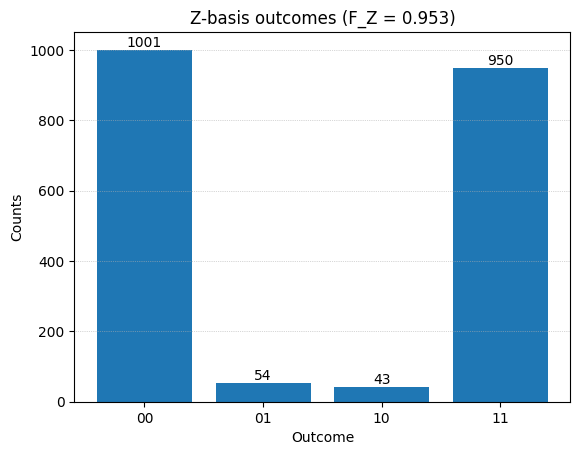

In [6]:
import matplotlib.pyplot as plt

# Visualize the Bell-state measurement distribution when data is available.
experiment_result = (qonscious_result or {}).get('experiment_result')  # type: ignore[union-attr]

if not experiment_result:
    print("No experiment result available; the visualization step is skipped.")
else:
    counts = experiment_result.get('counts', {})
    labels = ['00', '01', '10', '11']
    values = [counts.get(k, 0) for k in labels]

    total_shots = sum(values)
    fidelity_z = (
        (counts.get('00', 0) + counts.get('11', 0)) / total_shots
        if total_shots else float('nan')
    )
    title = f"Z-basis outcomes (F_Z = {fidelity_z:.3f})"

    fig, ax = plt.subplots()
    bars = ax.bar(labels, values)
    ax.set_title(title)
    ax.set_xlabel("Outcome")
    ax.set_ylabel("Counts")
    ax.set_ylim(bottom=0)
    ax.grid(True, axis='y', linestyle=':', linewidth=0.5)

    for bar, value in zip(bars, values):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            str(value),
            ha='center',
            va='bottom',
        )

    plt.show()


## Interpretation Guide
- Successful runs provide a JSON summary of FoM metrics that you can store alongside experiment metadata.
- Failed runs highlight which thresholds were breached, helping decide whether to recalibrate or reschedule.
- The measurement plot surfaces readout skew; consider repeating the validation after noise-mitigation updates.
